**K-means**

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
import re

In [2]:
# Text preprocessing function
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    return text


unsup_dir = Path('aclImdb') / 'train' / 'unsup'
if not unsup_dir.exists():
    raise FileNotFoundError(f"Directory not found: {unsup_dir}")
unsup_texts = []
for file_path in unsup_dir.glob('*.txt'):
    raw = file_path.read_text(encoding='utf-8')
    unsup_texts.append(preprocess_text(raw))

print(f"Loaded {len(unsup_texts)} unlabeled samples from {unsup_dir}")

df_unsup = pd.DataFrame({'text': unsup_texts})
df_unsup.head()



Loaded 50000 unlabeled samples from aclImdb\train\unsup


,text
0,i admit the great majority of films released b...
1,take a low budget inexperienced actors doublin...
2,everybody has seen back to the future right wh...
3,doris day was an icon of beauty in singing and...
4,after a series of silly funloving movies was a...


In [ ]:
# TF-IDF

custom_stop = set(ENGLISH_STOP_WORDS)
custom_stop.discard('not')
vectorizer = TfidfVectorizer(
    stop_words=list(custom_stop),
    max_df=0.8,
    min_df=5,
    ngram_range=(1,2),    
    sublinear_tf=True,    
    norm='l2'             
)

X_tfidf = vectorizer.fit_transform(df_unsup['text'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

# SVD
svd = TruncatedSVD(n_components=500, random_state=24)
X_svd = svd.fit_transform(X_tfidf)
print(f"SVD explained variance (100 components): {svd.explained_variance_ratio_.sum():.2%}")

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X_svd)
print(f"Preprocessed dataset shape: {X.shape}")



TF-IDF matrix shape: (50000, 151301)
SVD explained variance (100 components): 12.31%
Preprocessed dataset shape: (50000, 500)



Top 5 terms per cluster for k=2:
 Cluster 0: film, not, movie, story, great
 Cluster 1: movie, not, just, like, bad

Top 5 terms per cluster for k=3:
 Cluster 0: film, not, movie, great, story
 Cluster 1: film, not, like, just, movie
 Cluster 2: movie, not, bad, just, like

Top 5 terms per cluster for k=5:
 Cluster 0: effects, special effects, special, movie, film
 Cluster 1: film, not, films, story, movie
 Cluster 2: movie, bad, not, just, worst
 Cluster 3: not, film, like, just, movie
 Cluster 4: movie, not, great, like, good


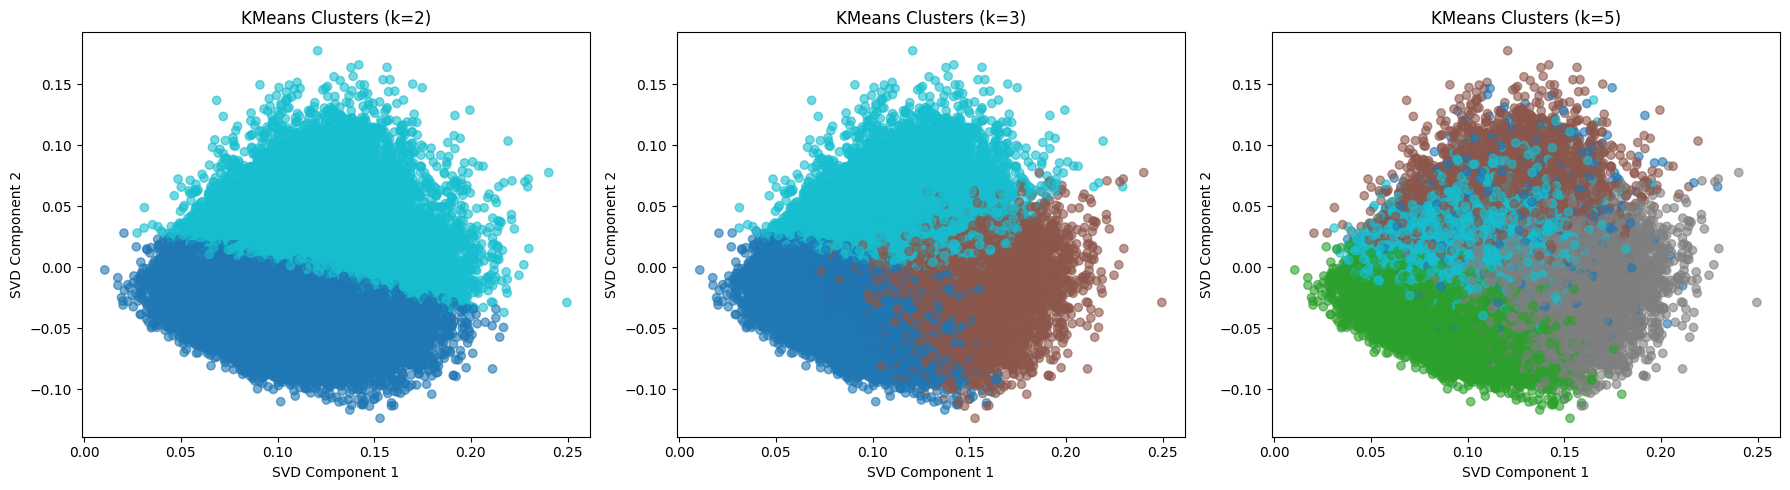

In [28]:
kmeans_models = {}
terms = vectorizer.get_feature_names_out()


X_vis = X_svd[:, :2]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, k in zip(axes, [2, 3, 5]):

    km = KMeans(n_clusters=k, random_state=24, n_init=10)
    km.fit(X_tfidf)
    kmeans_models[k] = km

    # Print top 5 terms per cluster
    print(f"\nTop 5 terms per cluster for k={k}:")
    order = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(k):
        top_terms = [terms[idx] for idx in order[i, :5]]
        print(f" Cluster {i}: {', '.join(top_terms)}")

    # Visualize clusters in 2D
    ax.scatter(X_vis[:, 0], X_vis[:, 1], c=km.labels_, cmap='tab10', alpha=0.6)
    ax.set_title(f'KMeans Clusters (k={k})')
    ax.set_xlabel('SVD Component 1')
    ax.set_ylabel('SVD Component 2')

plt.tight_layout()
plt.show()



In [29]:
for k, km in sorted(kmeans_models.items()):
    labels = km.labels_
    counts = [(labels == i).sum() for i in range(k)]
    print(f"\nNumber of data points per cluster for k={k}:")
    for idx, count in enumerate(counts):
        print(f" Cluster {idx}: {count}")



Number of data points per cluster for k=2:
 Cluster 0: 28075
 Cluster 1: 21925

Number of data points per cluster for k=3:
 Cluster 0: 21723
 Cluster 1: 12471
 Cluster 2: 15806

Number of data points per cluster for k=5:
 Cluster 0: 1952
 Cluster 1: 17405
 Cluster 2: 7966
 Cluster 3: 10446
 Cluster 4: 12231


In [30]:
import joblib


for k, km in kmeans_models.items():
    filename = f'kmeans_model_k{k}.pkl'
    joblib.dump(km, filename)
    print(f"Saved KMeans model for k={k} to {filename}")


Saved KMeans model for k=2 to kmeans_model_k2.pkl
Saved KMeans model for k=3 to kmeans_model_k3.pkl
Saved KMeans model for k=5 to kmeans_model_k5.pkl
